##### Importing Libraries

In [18]:
#importing libraries required
#-----------------------------------------------------------------------------------------------------------------
from __future__ import print_function, division
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import argparse
import copy
import datetime
from PyAstronomy import pyasl
import math
from matplotlib.gridspec import GridSpec
global low, up
from astropy.io import fits as f
from astropy.table import Table as t
from astropy.utils.data import download_file
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from mpl_toolkits import mplot3d
from scipy.optimize import curve_fit
import scipy.optimize as so
import warnings
warnings.filterwarnings("ignore")
#-----------------------------------------------------------------------------------------------------------------
#RA and Dec
#"RA- 279.11249  Dec- -8.22694"
RA= "$18h36m$" 
Dec= "-8.22694$^{\circ}$"
HI = 1420.04#*(10**6)
c = 299792.458 #km/s                         #speed of light

##### Radial Velocity Correction

In [19]:
########################################################################################################################
#--------------------------------------------radial_velocity_correction------------------------------------------------ 
# Coordinates of telescope
longitude = 75.857727
latitude = 22.719568
altitude = 554

# Coordinates of source (RA2000, DEC2000) RA_hr RA_min RA_sec DEC_deg DEC_min DEC_sec.
# Note that DEC must be signed + or -.
hd1 = "18 36 07.85 -08 19 30.20"  #scutum
hd2 = "17 45 40 -29 0 28"         #Sagittarius A
obs_ra_2000, obs_dec_2000 = pyasl.coordsSexaToDeg(hd1)

# Time of observation converted to Julian Date
dt1 = datetime.datetime(2022, 8, 29, 20, 49, 43)
jd = pyasl.jdcnv(dt1)

# Calculate barycentric correction (debug=True show
# various intermediate results)
corr, hjd = pyasl.helcorr(longitude, latitude, altitude, obs_ra_2000, obs_dec_2000, jd, debug=True)

print("Barycentric correction [km/s]: ", corr)
print("Heliocentric Julian day: ", hjd)

# Calculate LSR correction
v_sun = 20.5 # peculiar velocity (km/s) of sun w.r.t. LSR (The Solar Apex. Nature 162, 920 (1948). https://doi.org/10.1038/162920a0)
# solar apex
sun_ra = math.radians(270.2)
sun_dec = math.radians(28.7)

obs_dec = math.radians(obs_dec_2000)
obs_ra = math.radians(obs_ra_2000)

# equation from https://icts-yebes.oan.es/reports/doc/IT-CDT-2014-10.pdf
a = math.cos(sun_dec) * math.cos(obs_dec)
b = (math.cos(sun_ra) * math.cos(obs_ra)) + (math.sin(sun_ra) * math.sin(obs_ra))
c = math.sin(sun_dec) * math.sin(obs_dec)
v_rs = v_sun * ((a * b) + c)

v_lsr = corr + v_rs
print("LSR correction [km/s]: ", -v_lsr)
print("Positive value means receding (redshift) source, negative value means approaching (blueshift) source")
########################################################################################################################


----- HELCORR.PRO - DEBUG INFO - START ----
(obs_long (East positive),obs_lat,obs_alt) Observatory coordinates [deg,m]:  75.857727 22.719568 554
(ra,dec) Object coordinates (for epoch 2000.0) [deg]:  279.03270833333335 -8.325055555555556
(ra,dec) Object coordinates (precessed to epoch 2022.746119) [deg]:  279.34242926875896 -8.304836377641319
(ut) Universal time (middle of exposure) [hrs]:  20.828611113131046
(jd) Julian date (middle of exposure) (JD):  2459821.3678587964
(hjd) Heliocentric Julian date (middle of exposure) (HJD):  2459821.37096033
(gmst) Greenwich mean sidereal time [hrs]:  19.364665826655255
(lmst) Local mean sidereal time [hrs]:  0.4218476266552216
(dlat) Latitude correction [deg]:  -492.42182092923696
(lat) Geocentric latitude of observer [deg]:  22.582784160852988
(r) Distance of observer from center of earth [m]:  6375582.819588338
(v) Rotational velocity of earth at the position of the observer [km/s]:  0.46491488566839945
(vdiurnal) Projected earth rotation and

##### PLotting from LAB

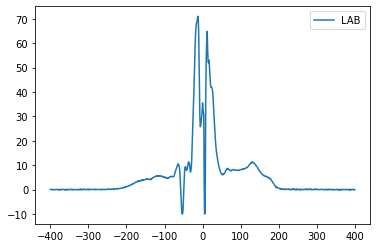

In [20]:
######################################################v_LAB#############################################################
#-----------------------------------------------------------------------------------------------------------------
#importing data from my GitHub
LAB = '/home/dev/Project_H1_line_detection/LAB_spectrum_SAG.csv'
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)
SURVEY = pd.read_csv(LAB)
#print(SURVEY)
#-----------------------------------------------------------------------------------------------------------------
# accessing the different columns of the csv SURVEY I made above
SURVEY.columns = ["v_lsr","T_B"]
#storing values for each column into a separate arrays
v_LAB = np.array(SURVEY.v_lsr)           # Values of velocity
T_B= np.array(SURVEY.T_B)                # Values of temperature
#-----------------------------------------------------------------------------------------------------------------
mu = 1420*(1 - (v_LAB/c))                # Calculating frequency using Doppler formula
y = np.mean(mu,axis=0)              
#-----------------------------------------------------------------------------------------------------------------
k = 1.38 *(10**(-23))                    #Boltzmann's Constant
N = k*T_B                                #noise power spectral density
#-----------------------------------------------------------------------------------------------------------------
plt.plot(v_LAB,T_B,label= "LAB")
# plt.xlim(1420,1420.5)
plt.legend()
plt.show()

##### Plotting from self observations

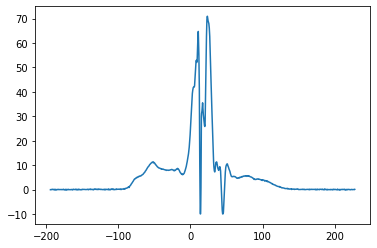

In [21]:
#importing data from my GitHub
from ctypes.wintypes import HICON

OBS = '/home/dev/Project_H1_line_detection/observation.txt'
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)
obs = pd.read_csv(OBS)
# print(obs)
#-----------------------------------------------------------------------------------------------------------------
# accessing the different columns of the csv SURVEY I made above
obs.columns = ["mu","P"]
#storing values for each column into a separate arrays
MU = np.array(obs.mu)           # Values of velocity
P= np.array(obs.P)              # Values of temperature
#-----------------------------------------------------------------------------------------------------------------
v_obs = 299790*(1- (MU/HI)) - v_lsr
T_B_interp = interp.interp1d(np.arange(T_B.size),T_B)
T_B_stretch = T_B_interp(np.linspace(0,T_B.size-1,MU.size))
# print(v_obs)
plt.plot(v_obs,T_B_stretch)
plt.show()

##### Comparison Plot

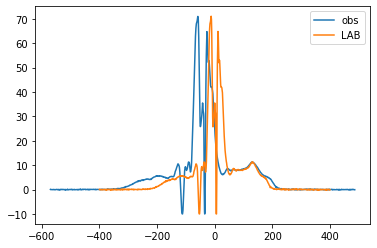

In [22]:
plt.plot(v_obs*(-2.5),T_B_stretch,label = "obs")
plt.plot(v_LAB,T_B,label = "LAB")
plt.legend()
plt.show()

##### Rotation Curve

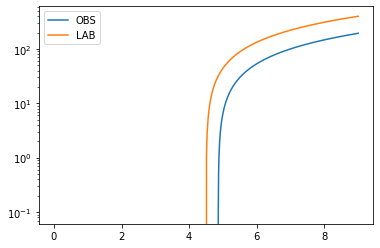

In [23]:
radius1 = np.linspace(0,9,len(v_obs))
radius2 = np.linspace(0,9,len(v_LAB))
plt.plot(radius1,-v_obs, label = "OBS")
plt.plot(radius2,v_LAB, label = "LAB")
plt.legend()
plt.yscale('log')
plt.show()

In [24]:
# sigma = 5.670 * 10**8 
# rad =np.sqrt(P/(sigma* (T_B_stretch**4))*np.pi)/10**3
# rad = rad[~np.isnan(rad)]
# # print(rad)
# V_max = np.max(-v_obs)
# R_max = np.max(rad)

# # print(V_max,R_max)

# def func1(R_max,V_max,n):
#   numerator = V_max*(1200/R_max)
#   denominator = ((1/3)+ ((2/3)*((1200/R_max)**n)))**(3/(2*n))
#   v_rot = numerator/denominator
#   plt.scatter(rad,v_rot)
#   return v_rot

# plt.plot(rad,v_obs)
# plt.xlabel("$Radius \longrightarrow$")
# plt.ylabel("$V_{Rot} \longrightarrow $")
# # func1(R_max,V_max,)
# # plt.legend()
# plt.show()



#### **LAB survey parameters** - 
The effective beamsize includes telescope beam and beam smearing due to interpolation. 

The beam for LAB is 36 arcmin for declinations > -27.5 deg (25m Dwingeloo telescope)

                and 30 arcmin for declinations < -27.5 deg (30m Villa Elisa telescope).

Due to interpolations the minimum effective FWHM beam is 40 arcmin for the LAB for declinations > -27 deg 

                                             and 35 arcmin for declinations < -27 deg.


#### **Feed horn setup parameters** - 
Beamwidth is 35 degree

FWHM is 35 degree

Spectral resolution is 1MHz

In [25]:
print("LAB survey parameters - \n The effective beamsize includes telescope beam and beam smearing due to interpolation. \n The beam for LAB is 36 arcmin for declinations > -27.5 deg (25m Dwingeloo telescope) \n                 and 30 arcmin for declinations < -27.5 deg (30m Villa Elisa telescope). \n Due to interpolations the minimum effective FWHM beam is 40 arcmin for the LAB for declinations > -27 deg \n                                                      and 35 arcmin for declinations < -27 deg.")

print("Feed horn setup parameters - \n Beamwidth is 35 degree \n FWHM is 35 degree \n Spectral resolution is 1MHz")

LAB survey parameters - 
 The effective beamsize includes telescope beam and beam smearing due to interpolation. 
 The beam for LAB is 36 arcmin for declinations > -27.5 deg (25m Dwingeloo telescope) 
                 and 30 arcmin for declinations < -27.5 deg (30m Villa Elisa telescope). 
 Due to interpolations the minimum effective FWHM beam is 40 arcmin for the LAB for declinations > -27 deg 
                                                      and 35 arcmin for declinations < -27 deg.
Feed horn setup parameters - 
 Beamwidth is 35 degree 
 FWHM is 35 degree 
 Spectral resolution is 1MHz
